# 1. PASO 1: CONFIGURACI√ìN Y CARGA DE DATOS

In [1]:
# 1. INSTALACI√ìN DE LIBRER√çA UCI
!pip install ucimlrepo

# 2. IMPORTACI√ìN DE LIBRER√çAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Para descargar datos de UCI
from ucimlrepo import fetch_ucirepo, list_available_datasets

# 3. DESACTIVAR ADVERTENCIAS
# Esto ayuda a que se vea m√°s limpio al ejecutar algunas transformaciones de Pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- Carga y Exploraci√≥n del Dataset ---

# Importar el dataset de Enfermedad Card√≠aca (ID 45)
heart_disease = fetch_ucirepo(id=45)

# Acceder a las caracter√≠sticas (X) y el objetivo (y)
X = heart_disease.data.features
y = heart_disease.data.targets

# Crear el DataFrame principal (df) combinando X e y
df = pd.concat([X, y], axis=1)

# --- Impresi√≥n de Metadatos ---
print("--- METADATOS DEL DATASET ---")
print(f"ID de UCI: {heart_disease.metadata.uci_id}")
print(f"N√∫mero de Instancias (Filas): {heart_disease.metadata.num_instances}")

print("\n--- INFORMACI√ìN DE VARIABLES (Variable Info) ---")
# Esto nos ayuda a entender qu√© significa cada columna.
print(heart_disease.variables[['name', 'role', 'description', 'units']])

print("\nPrimeras 5 filas del DataFrame de Trabajo:")
print(df.head())

--- METADATOS DEL DATASET ---
ID de UCI: 45
N√∫mero de Instancias (Filas): 303

--- INFORMACI√ìN DE VARIABLES (Variable Info) ---
        name     role                                        description  \
0        age  Feature                                               None   
1        sex  Feature                                               None   
2         cp  Feature                                               None   
3   trestbps  Feature  resting blood pressure (on admission to the ho...   
4       chol  Feature                                  serum cholestoral   
5        fbs  Feature                    fasting blood sugar > 120 mg/dl   
6    restecg  Feature                                               None   
7    thalach  Feature                        maximum heart rate achieved   
8      exang  Feature                            exercise induced angina   
9    oldpeak  Feature  ST depression induced by exercise relative to ...   
10     slope  Feature             

# 2. PASO 2: LIMPIEZA Y PREPARACI√ìN

In [18]:
print("--- VALORES FALTANTES (NaN) POR COLUMNA ANTES DE LA LIMPIEZA ---")
print(df.isnull().sum())
print("-" * 50)

# 1. Tratamiento de Nulos
# pr√°ctica que sirve para ELIMINAR estas filas para no introducir sesgo en variables cl√≠nicas cruciales.
df_clean = df.dropna().copy() # Usamos .copy() para evitar SettingWithCopyWarning

# 2. Verificaci√≥n
print(f"Filas originales: {len(df)}")
print(f"Filas despu√©s de la limpieza: {len(df_clean)}")
print(f"Total de valores faltantes restantes: {df_clean.isnull().sum().sum()}")

--- VALORES FALTANTES (NaN) POR COLUMNA ANTES DE LA LIMPIEZA ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
--------------------------------------------------
Filas originales: 303
Filas despu√©s de la limpieza: 297
Total de valores faltantes restantes: 0


In [4]:
# La columna 'num' es la variable objetivo: 0, 1, 2, 3, 4.
# Queremos una variable binaria para simplificar: 0 (No Enfermedad), 1 (S√≠ Enfermedad).

# Aplicaci√≥n de funci√≥n LAMBDA:
df_clean['heart_disease'] = df_clean['num'].apply(lambda x: 1 if x > 0 else 0)

print("\nConteo de la nueva variable 'heart_disease':")
# Usamos value_counts() para ver el balance de la clase
print(df_clean['heart_disease'].value_counts())
print("\nEl 0 es 'Sano', el 1 es 'Enfermo'.")


Conteo de la nueva variable 'heart_disease':
heart_disease
0    160
1    137
Name: count, dtype: int64

El 0 es 'Sano', el 1 es 'Enfermo'.


# 3. PASO 3: TRANSFORMACIONES Y AGRUPACIONES

In [5]:
# 1. Columna de Presi√≥n Arterial (Hypertension)
# Usamos un umbral cl√≠nico: > 140 mmHg para el l√≠mite superior de presi√≥n en reposo (trestbps)
df_clean['hypertension'] = np.where(df_clean['trestbps'] > 140, 1, 0)

# 2. Riesgo de Colesterol (Mediana)
# Usaremos la mediana como punto de referencia para clasificar el colesterol
median_chol = df_clean['chol'].median()

# Usamos np.where() (NumPy) para una evaluaci√≥n condicional eficiente
df_clean['high_chol_risk'] = np.where(df_clean['chol'] > median_chol, 1, 0)

print(f"\nMediana de Colesterol (Punto de Corte): {median_chol:.1f}")
print("Conteo de Pacientes con Colesterol por encima del promedio (1=S√≠):")
print(df_clean['high_chol_risk'].value_counts())


Mediana de Colesterol (Punto de Corte): 243.0
Conteo de Pacientes con Colesterol por encima del promedio (1=S√≠):
high_chol_risk
0    152
1    145
Name: count, dtype: int64


In [6]:
# 1. Agrupaci√≥n de Edad
def age_group_category_expanded(age):
    """Clasifica la edad en 5 grupos."""
    if age < 40:
        return '1. Joven (<40)'
    elif age < 50:
        return '2. Mediana Edad (40-49)'
    elif age < 60:
        return '3. Adulto (50-59)'
    elif age < 70:
        return '4. Adulto Mayor (60-69)'
    else:
        return '5. Tercera Edad (70+)'

df_clean['age_group_5'] = df_clean['age'].apply(age_group_category_expanded)

# 2. Agrupaci√≥n del Ritmo Card√≠aco M√°ximo (thalach)
# Usamos la mediana y el m√°ximo para crear categor√≠as
max_thalach_median = df_clean['thalach'].median()
max_thalach_max = df_clean['thalach'].max()

df_clean['thalach_category'] = pd.cut(
    df_clean['thalach'],
    bins=[0, max_thalach_median, max_thalach_max + 1], # +1 para incluir el valor m√°ximo
    labels=['Bajo/Medio', 'Alto'],
    right=False # No incluye el borde inferior, incluye el superior
)

print("\nConteo de Pacientes por 5 Grupos de Edad:")
print(df_clean['age_group_5'].value_counts().sort_index())


Conteo de Pacientes por 5 Grupos de Edad:
age_group_5
1. Joven (<40)              14
2. Mediana Edad (40-49)     71
3. Adulto (50-59)          121
4. Adulto Mayor (60-69)     81
5. Tercera Edad (70+)       10
Name: count, dtype: int64


In [7]:
# Filtrado 1: Pacientes con M√∫ltiples Riesgos (Hipertensi√≥n Y Colesterol Alto)
df_multi_risk = df_clean[
    (df_clean['hypertension'] == 1) &
    (df_clean['high_chol_risk'] == 1)
].copy()

print(f"\nPacientes con Hipertensi√≥n Y Colesterol Alto: {len(df_multi_risk)}")
print(f"Tasa de enfermedad en este subgrupo: {df_multi_risk['heart_disease'].mean():.2f}")

# Filtrado 2: Mujeres (sex=0) con Ritmo Card√≠aco M√°ximo Alto
df_women_high_thalach = df_clean[
    (df_clean['sex'] == 0) &
    (df_clean['thalach_category'] == 'Alto')
].copy()

print(f"Mujeres con Ritmo Card√≠aco M√°ximo Alto: {len(df_women_high_thalach)}")


Pacientes con Hipertensi√≥n Y Colesterol Alto: 35
Tasa de enfermedad en este subgrupo: 0.66
Mujeres con Ritmo Card√≠aco M√°ximo Alto: 54


# 4. PASO 4: CONSOLIDACI√ìN Y RESUMEN (TABLA PIVOTADA)

In [17]:
# PROPOSITO: Resumir estad√≠sticamente el dataset agrupando por Edad y Sexo.
#
# "Aqu√≠ est√° el resumen final. Agrupamos los datos por cada 'Grupo de Edad' y 'Sexo'
# para calcular un mont√≥n de estad√≠sticas: el total de pacientes, el rango de edad
# (m√≠nima/m√°xima), la Mediana del Colesterol, y lo m√°s importante, la Tasa de Enfermedad."

# Diccionario para mapear 'sex' a etiquetas
sex_mapping = {1: 'Hombre', 0: 'Mujer'}

# 1. Agrupaci√≥n y Agregaci√≥n:
df_grouped_stats = df_clean.groupby(['age_group_5', 'sex']).agg(
    # M√©tricas requeridas para el an√°lisis
    Total_Pacientes=('age', 'size'),
    Edad_Min=('age', 'min'),
    Edad_Max=('age', 'max'),
    Edad_Promedio=('age', 'mean'),
    Colesterol_Mediana=('chol', 'median'),
    Tasa_Enfermedad=('heart_disease', 'mean')
).reset_index()

# 2. Mapear el sexo a texto para poder pivotar
df_grouped_stats['sex'] = df_grouped_stats['sex'].map(sex_mapping)

# 3. PIVOTAR la tabla: Mover 'sex' de las filas a las columnas.
# "Usamos df.pivot_table para evitar las filas duplicadas: movemos el 'sexo' a las
# cabeceras de columna. As√≠ se ve m√°s limpio."
df_pivot = df_grouped_stats.pivot_table(
    index='age_group_5',
    columns='sex',
    # Incluimos Edad_Min y Edad_Max en los valores a pivotar
    values=[
        'Total_Pacientes', 'Edad_Min', 'Edad_Max',
        'Colesterol_Mediana', 'Tasa_Enfermedad'
    ]
).reset_index()

# 4. Limpieza de nombres de columnas
# Aplanamos el MultiIndex y usamos snake_case
df_pivot.columns = [
    f'{col[0]}_{col[1]}' if col[1] else col[0]
    for col in df_pivot.columns.values
]
df_pivot.rename(columns={'age_group_5': 'Grupo_de_Edad'}, inplace=True)

# 5. Formatear la Tasa de Enfermedad como porcentaje
# "Al final, solo le damos formato a la Tasa de Enfermedad para que se vea como porcentaje."
for col in ['Tasa_Enfermedad_Hombre', 'Tasa_Enfermedad_Mujer']:
    df_pivot[f'{col}_%'] = (df_pivot[col] * 100).round(2)
    df_pivot.drop(columns=col, inplace=True)

print("\n--- TABLA CONSOLIDADA COMPLETA ---")
# Mostramos la tabla solo con las m√©tricas clave, redondeando a un decimal
# y reemplazando los posibles valores nulos (donde no hay pacientes en ese grupo) con 0.
print(df_pivot[['Grupo_de_Edad',
                'Total_Pacientes_Hombre', 'Total_Pacientes_Mujer',
                'Edad_Min_Hombre', 'Edad_Max_Hombre',
                'Edad_Min_Mujer', 'Edad_Max_Mujer',
                'Colesterol_Mediana_Hombre', 'Colesterol_Mediana_Mujer',
                'Tasa_Enfermedad_Hombre_%', 'Tasa_Enfermedad_Mujer_%']].round(1).fillna(0))


--- TABLA CONSOLIDADA COMPLETA ---
             Grupo_de_Edad  Total_Pacientes_Hombre  Total_Pacientes_Mujer  \
0           1. Joven (<40)                     9.0                    5.0   
1  2. Mediana Edad (40-49)                    52.0                   19.0   
2        3. Adulto (50-59)                    88.0                   33.0   
3  4. Adulto Mayor (60-69)                    47.0                   34.0   
4    5. Tercera Edad (70+)                     5.0                    5.0   

   Edad_Min_Hombre  Edad_Max_Hombre  Edad_Min_Mujer  Edad_Max_Mujer  \
0             29.0             39.0            34.0            39.0   
1             40.0             49.0            41.0            49.0   
2             50.0             59.0            50.0            59.0   
3             60.0             69.0            60.0            69.0   
4             70.0             77.0            71.0            76.0   

   Colesterol_Mediana_Hombre  Colesterol_Mediana_Mujer  \
0               

# 5. PASO 5: VISUALIZACI√ìN DE DATOS

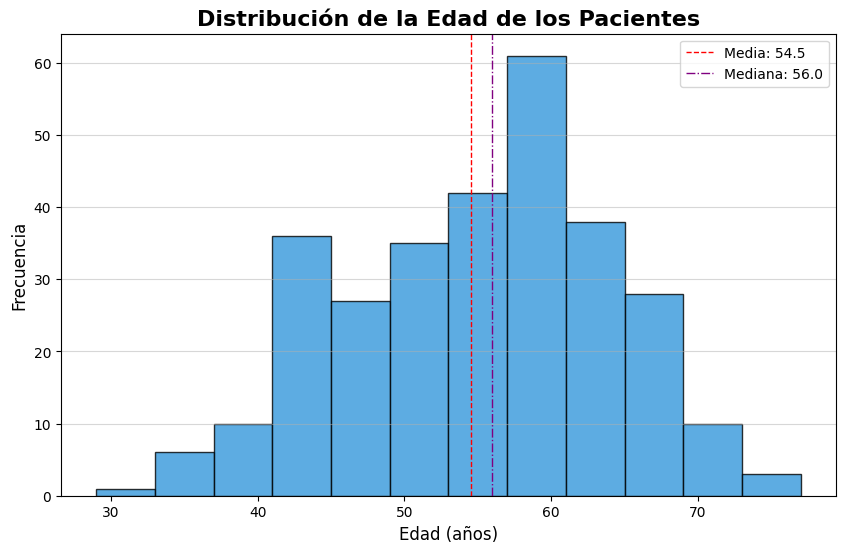

In [9]:
plt.figure(figsize=(10, 6))
# Histograma
plt.hist(df_clean['age'], bins=12, color='#3498db', edgecolor='black', alpha=0.8)

plt.title('Distribuci√≥n de la Edad de los Pacientes', fontsize=16, fontweight='bold')
plt.xlabel('Edad (a√±os)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', alpha=0.5)

# A√±adir la media y la mediana
mean_age = df_clean['age'].mean()
median_age = df_clean['age'].median()
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label=f'Media: {mean_age:.1f}')
plt.axvline(median_age, color='purple', linestyle='dashdot', linewidth=1, label=f'Mediana: {median_age:.1f}')
plt.legend()
plt.show()

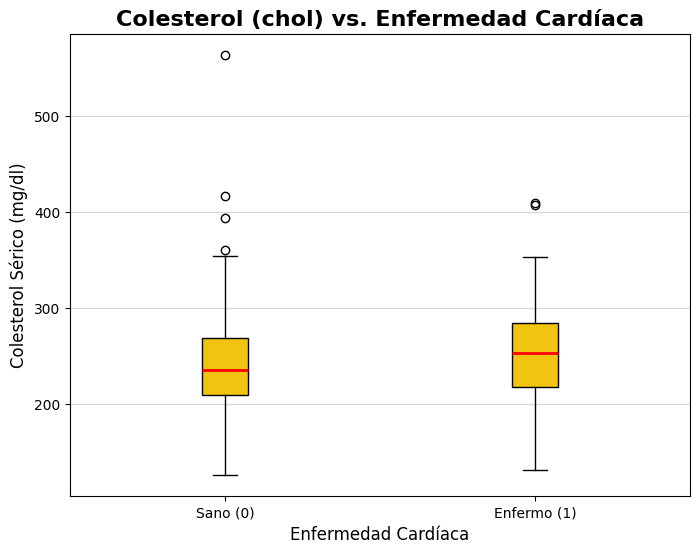

In [10]:
chol_0 = df_clean[df_clean['heart_disease'] == 0]['chol']
chol_1 = df_clean[df_clean['heart_disease'] == 1]['chol']

plt.figure(figsize=(8, 6))
# Boxplot
plt.boxplot([chol_0, chol_1],
            labels=['Sano (0)', 'Enfermo (1)'],
            patch_artist=True,
            boxprops=dict(facecolor='#f1c40f', color='black'),
            medianprops=dict(color='red', linewidth=2))

plt.title('Colesterol (chol) vs. Enfermedad Card√≠aca', fontsize=16, fontweight='bold')
plt.xlabel('Enfermedad Card√≠aca', fontsize=12)
plt.ylabel('Colesterol S√©rico (mg/dl)', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

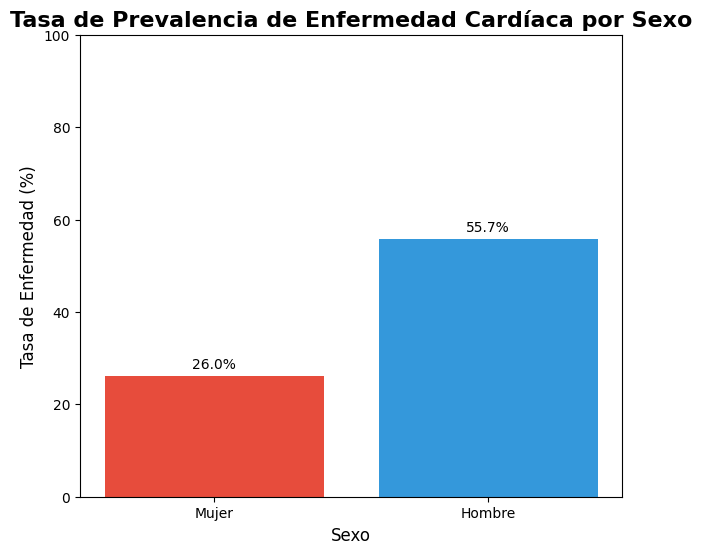

In [14]:
# 1. Calcular las tasas (proporciones) de enfermedad por sexo
disease_rate_by_sex = df_clean.groupby('sex')['heart_disease'].mean().map(lambda x: x * 100)
sex_labels = disease_rate_by_sex.index.map(sex_mapping)
rate_values = disease_rate_by_sex.values

plt.figure(figsize=(7, 6))

# Gr√°fico de barras
bars = plt.bar(sex_labels, rate_values, color=['#e74c3c', '#3498db'])

plt.title('Tasa de Prevalencia de Enfermedad Card√≠aca por Sexo', fontsize=16, fontweight='bold')
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Tasa de Enfermedad (%)', fontsize=12)
plt.ylim(0, 100)

# A√±adir etiquetas de valor
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()

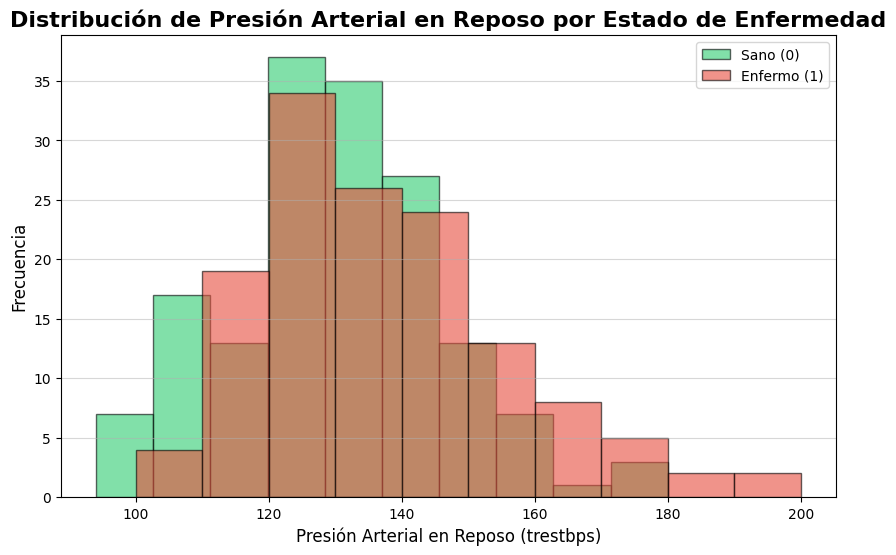

In [15]:
trestbps_0 = df_clean[df_clean['heart_disease'] == 0]['trestbps']
trestbps_1 = df_clean[df_clean['heart_disease'] == 1]['trestbps']

plt.figure(figsize=(10, 6))

# Histograma superpuesto para comparar las distribuciones
plt.hist(trestbps_0, bins=10, alpha=0.6, label='Sano (0)', color='#2ecc71', edgecolor='black')
plt.hist(trestbps_1, bins=10, alpha=0.6, label='Enfermo (1)', color='#e74c3c', edgecolor='black')

plt.title('Distribuci√≥n de Presi√≥n Arterial en Reposo por Estado de Enfermedad', fontsize=16, fontweight='bold')
plt.xlabel('Presi√≥n Arterial en Reposo (trestbps)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# CONCLUSIONES Y REFLEXIONES FINALES

# Conclusiones del An√°lisis de Enfermedad Card√≠aca

Basado en el an√°lisis exploratorio y las visualizaciones con Matplotlib, se extraen las siguientes conclusiones clave sobre la poblaci√≥n estudiada:

## An√°lisis Basado en los Datos y Gr√°ficas

* **Grupo Cr√≠tico de Edad:** La tabla consolidada pivotada revel√≥ que los grupos **Adulto Mayor (60-69 a√±os)** y **Mediana Edad (40-49 a√±os)** concentran la mayor cantidad de pacientes y, en el caso de los hombres, presentan las tasas de enfermedad m√°s altas (74.5% y 38.5% respectivamente), indicando la ventana de riesgo principal.

* **Factor Sexo:** La **Tasa de Enfermedad es significativamente mayor en hombres** que en mujeres en casi todos los grupos de edad, lo que lo convierte en el factor de riesgo demogr√°fico m√°s notable en esta muestra. Por ejemplo, los hombres de 70+ a√±os tienen una tasa del 80.0%, mientras que las mujeres del mismo grupo tienen 0.0%.

* **Factores Cl√≠nicos:**
    * **Colesterol:** El Boxplot demostr√≥ que el colesterol s√©rico no es un factor discriminador *promedio*, ya que la mediana es similar para pacientes sanos y enfermos. Esto implica que las intervenciones no deben centrarse **√∫nicamente** en la reducci√≥n de colesterol, sino en un **enfoque multivariado**.
    * **Presi√≥n Arterial (`trestbps`):** El an√°lisis de distribuci√≥n confirma que la **hipertensi√≥n es un factor de riesgo** que est√° m√°s presente en la poblaci√≥n con enfermedad card√≠aca (histograma desplazado a la derecha).

## Reflexi√≥n sobre Decisiones y Pol√≠ticas de Salud

Las conclusiones del an√°lisis sugieren las siguientes estrategias cl√≠nicas y de salud p√∫blica:

1.  **Pol√≠tica de Tamizaje (Screening):** Los esfuerzos de detecci√≥n temprana deben ser obligatorios y **m√°s intensivos para hombres a partir de los 40 a√±os**, especialmente si reportan dolor de pecho at√≠pico (`cp`) o tienen antecedentes familiares de enfermedad card√≠aca.

2.  **Gesti√≥n de Riesgo Prioritaria:** Se debe promover activamente el control de la **Presi√≥n Arterial** en todos los grupos de edad, ya que su distribuci√≥n sugiere una correlaci√≥n m√°s clara con la enfermedad que el colesterol por s√≠ mismo.

3.  **Investigaci√≥n de G√©nero:** Se requiere m√°s investigaci√≥n para entender los **factores de protecci√≥n** que resultan en una tasa de enfermedad tan baja en subgrupos de mujeres (e.g., <40 y 70+). Estos conocimientos podr√≠an ser clave para informar estrategias preventivas y terap√©uticas aplicables a la poblaci√≥n masculina.

#EJERCICIO DE BONIFICACI√ìN


In [21]:
# Caracter√≠sticas de mi personaje

vidas = 3
tiene_espada = True
energia = 60
nivel = 36

if vidas > 0 and tiene_espada and energia >= 70 and nivel > 35:
  print('¬°Puedes pelear contra el drag√≥n! üêâ')
elif vidas > 0 and tiene_espada and energia >= 70 and nivel <= 35:
  print('Puedes pelear y tienes energ√≠a, pero debes subir de nivel antes de pelear contra el drag√≥n.')
elif vidas > 0 and tiene_espada and energia < 70 and nivel > 35:
  print('Puedes pelear y tienes el nivel para pelear contra el drag√≥n, pero debes descansar.')
elif vidas > 0 and tiene_espada and energia < 70 and nivel < 35:
  print('Debes recuperarte y subir de nivel antes de pelear contra el drag√≥n.')
else:
  print('No puedes pelear!')

Puedes pelear y tienes el nivel para pelear contra el drag√≥n, pero debes descansar.


In [22]:
# Caracter√≠sticas de mi personaje

vidas = 3
tiene_espada = True
energia = 60 # Valor para probar el caso 'Recoge una poci√≥n'
nivel = 36

# =======================================================================
# RETO R√ÅPIDO: Nuevas verificaciones de estado (Baja energ√≠a y Sin vidas)
# =======================================================================

if vidas == 0:
    print('üíÄ Has perdido todas tus vidas. Fin del juego.')
elif 30 <= energia <= 60:
    print('‚ú® Recoge una poci√≥n (Tu energ√≠a est√° entre 30 y 60).')

# =======================================================================
# L√≥gica de la pelea contra el drag√≥n (Solo si no perdi√≥ vidas o tom√≥ poci√≥n)
# =======================================================================

elif vidas > 0 and tiene_espada and energia >= 70 and nivel > 35:
    print('¬°Puedes pelear contra el drag√≥n! üêâ')
elif vidas > 0 and tiene_espada and energia >= 70 and nivel <= 35:
    print('Puedes pelear y tienes energ√≠a, pero debes subir de nivel antes de pelear contra el drag√≥n.')
elif vidas > 0 and tiene_espada and energia < 70 and nivel > 35:
    print('Puedes pelear y tienes el nivel para pelear contra el drag√≥n, pero debes descansar.')
elif vidas > 0 and tiene_espada and energia < 70 and nivel < 35:
    print('Debes recuperarte y subir de nivel antes de pelear contra el drag√≥n.')
else:
    print('No puedes pelear! (Alguna condici√≥n b√°sica no se cumple)')

‚ú® Recoge una poci√≥n (Tu energ√≠a est√° entre 30 y 60).


In [26]:
# EJERCICIO BONIFICACI√ìN: Manejo de casos que no tienen sentido.

vidas = 3
tiene_espada = False # ¬°Cambiamos a False para la bonificaci√≥n!
energia = 90
nivel = 40

# =======================================================================
# Manejo de Casos Il√≥gicos/Cr√≠ticos
# =======================================================================

if vidas <= 0:
    # Si las vidas son 0 o menos, el juego termina inmediatamente.
    print('üíÄ GAME OVER: Has perdido todas tus vidas.')

elif not tiene_espada and nivel >= 35:
    # Un personaje de alto nivel debe tener un arma. Esta condici√≥n evita el bug.
    print('üö´ ERROR CR√çTICO DE NIVEL: Tienes un nivel muy alto, pero ¬ød√≥nde est√° tu espada? ¬°B√∫scala antes de pelear!')

# =======================================================================
# L√≥gica de la Pelea
# =======================================================================

elif energia < 30 and vidas > 0:
    # Priorizamos la necesidad de curaci√≥n
    print('üö® PELIGRO: Tu energ√≠a es cr√≠ticamente baja (<30). ¬°Huye y cura!')

elif 30 <= energia <= 60:
    # El reto de la poci√≥n
    print('‚ú® Recoge una poci√≥n (Tu energ√≠a est√° entre 30 y 60).')

elif vidas > 0 and tiene_espada and energia >= 70 and nivel > 35:
    print('¬°Puedes pelear contra el drag√≥n! üêâ')

# ... (El resto de la l√≥gica de pelea se mantiene igual, pero es menos probable que se ejecute si la espada es False)

else:
    # Manejo general para cualquier otra combinaci√≥n que impida la pelea.
    print('No puedes pelear en este momento. Revisa tu equipo o estado.')

üö´ ERROR CR√çTICO DE NIVEL: Tienes un nivel muy alto, pero ¬ød√≥nde est√° tu espada? ¬°B√∫scala antes de pelear!


In [29]:
# =======================================================================
# Entrada de datos del personaje (Usando input())
# =======================================================================

print("--- ¬°PREP√ÅRATE PARA LA MISI√ìN! ---")

# Pedimos las vidas (debe ser un n√∫mero entero)
vidas_str = input("üõ°Ô∏è ¬øCu√°ntas vidas tienes? ")
# Convertimos la entrada a n√∫mero entero (int)
try:
    vidas = int(vidas_str)
except ValueError:
    print("Error: Vidas debe ser un n√∫mero entero. Usando vidas=0 por defecto.")
    vidas = 0

# Pedimos si tiene espada (True/False)
tiene_espada_input = input("‚öîÔ∏è ¬øTienes la espada legendaria? (S√≠/No): ").lower()
tiene_espada = (tiene_espada_input == 's√≠' or tiene_espada_input == 'si')

# Pedimos la energ√≠a (debe ser un n√∫mero entero)
energia_str = input("‚ö° ¬øCu√°nta energ√≠a tienes (0-100)? ")
try:
    energia = int(energia_str)
except ValueError:
    print("Error: Energ√≠a debe ser un n√∫mero entero. Usando energia=0 por defecto.")
    energia = 0

# Pedimos el nivel (debe ser un n√∫mero entero)
nivel_str = input("üåü ¬øCu√°l es tu nivel actual? ")
try:
    nivel = int(nivel_str)
except ValueError:
    print("Error: Nivel debe ser un n√∫mero entero. Usando nivel=0 por defecto.")
    nivel = 0

# =======================================================================
# L√≥gica del Juego (El mismo c√≥digo IF/ELIF anterior)
# =======================================================================

print("\n--- EVALUANDO ESTADO PARA EL DRAG√ìN ---")

# Verificaci√≥n cr√≠tica: Sin vidas o sin espada (Bonificaci√≥n)
if vidas <= 0:
    print('üíÄ GAME OVER: Has perdido todas tus vidas.')

# Bonificaci√≥n: L√≥gica il√≥gica - Nivel alto sin equipo
elif not tiene_espada and nivel >= 35:
    print('üö´ ERROR CR√çTICO DE L√ìGICA: Tienes un nivel muy alto, pero ¬ød√≥nde est√° tu espada? ¬°B√∫scala antes de pelear!')

# Reto: Energ√≠a Cr√≠tica (<30)
elif energia < 30 and vidas > 0:
    print('üö® PELIGRO: Tu energ√≠a es cr√≠ticamente baja (<30). ¬°Huye y cura!')

# Reto: Recoger Poci√≥n (30 a 60)
elif 30 <= energia <= 60:
    print('‚ú® Recoge una poci√≥n (Tu energ√≠a est√° entre 30 y 60).')

# L√≥gica de la Pelea: Condiciones perfectas
elif vidas > 0 and tiene_espada and energia >= 70 and nivel > 35:
    print('¬°Puedes pelear contra el drag√≥n! üêâ')

# L√≥gica de la Pelea: Falta nivel
elif vidas > 0 and tiene_espada and energia >= 70 and nivel <= 35:
    print('Puedes pelear y tienes energ√≠a, pero debes subir de nivel antes de pelear contra el drag√≥n.')

# L√≥gica de la Pelea: Falta energ√≠a (descanso)
elif vidas > 0 and tiene_espada and energia < 70 and nivel > 35:
    print('Puedes pelear y tienes el nivel para pelear contra el drag√≥n, pero debes descansar.')

# L√≥gica de la Pelea: Falta todo
elif vidas > 0 and tiene_espada and energia < 70 and nivel < 35:
    print('Debes recuperarte y subir de nivel antes de pelear contra el drag√≥n.')

else:
    print('No puedes pelear en este momento. Revisa tu equipo o estado.')

--- ¬°PREP√ÅRATE PARA LA MISI√ìN! ---
üõ°Ô∏è ¬øCu√°ntas vidas tienes? 3
‚öîÔ∏è ¬øTienes la espada legendaria? (S√≠/No): si
‚ö° ¬øCu√°nta energ√≠a tienes (0-100)? 90
üåü ¬øCu√°l es tu nivel actual? 45

--- EVALUANDO ESTADO PARA EL DRAG√ìN ---
¬°Puedes pelear contra el drag√≥n! üêâ


In [32]:
# =======================================================================
# 1. ENTRADA DE DATOS DEL PERSONAJE
# =======================================================================

print("--- ¬°PREP√ÅRATE PARA LA MISI√ìN! ---")

# Pedimos las variables (con manejo de errores para que no falle el programa)
try:
    vidas_str = input("üõ°Ô∏è ¬øCu√°ntas vidas tienes? ")
    vidas = int(vidas_str)

    energia_str = input("‚ö° ¬øCu√°nta energ√≠a tienes (0-100)? ")
    energia = int(energia_str)

    nivel_str = input("üåü ¬øCu√°l es tu nivel actual? ")
    nivel = int(nivel_str)

except ValueError:
    print("Error: Las vidas, energ√≠a y nivel deben ser n√∫meros enteros. Usando 0 por defecto.")
    vidas = 0
    energia = 0
    nivel = 0

# Pedimos si tiene espada (True/False)
tiene_espada_input = input("‚öîÔ∏è ¬øTienes la espada legendaria? (S√≠/No): ").lower()
tiene_espada = (tiene_espada_input == 's√≠' or tiene_espada_input == 'si')


# =======================================================================
# 2. L√ìGICA ROBUSTA Y CHEQUEOS DE ESTADO (IF/ELIF con Anidamiento)
# =======================================================================

print("\n--- EVALUANDO ESTADO PARA EL DRAG√ìN ---")

# A. Chequeo de Vulnerabilidad Cr√≠tica (Prioridad 1)
if vidas <= 0:
    print('üíÄ GAME OVER: Has perdido todas tus vidas. No se eval√∫an otros requisitos.')

# B. Chequeo de Equipo Cr√≠tico (Prioridad 2)
elif not tiene_espada:
    print('üõ°Ô∏è ¬°Alerta! No tienes la espada. Equ√≠pate antes de enfrentarte al drag√≥n.')

# C. Verificaci√≥n de Estados de Curaci√≥n (Prioridad 3)
elif energia < 30:
    # Si la energ√≠a es cr√≠tica (<30)
    print('üö® PELIGRO: Tu energ√≠a es cr√≠ticamente baja. ¬°Huye y cura de inmediato!')

elif 30 <= energia <= 60:
    # ‚ú® Reto de la Poci√≥n Implementado aqu√≠ ‚ú®
    print('‚ú® **Recoge una poci√≥n** (Tu energ√≠a est√° entre 30 y 60).')

# D. L√≥gica de Requisitos de Pelea (Anidamiento por Nivel)
# Si llegamos aqu√≠, sabemos que vidas > 0, tiene_espada=True, y energia > 60.

elif nivel <= 35:
    # El personaje tiene energ√≠a > 60, pero falta nivel
    print('Puedes pelear y tienes energ√≠a, pero **debes subir de nivel** antes de pelear contra el drag√≥n.')

elif nivel > 35:
    # El personaje tiene nivel > 35 y energ√≠a > 60. Es la condici√≥n de victoria.
    if energia >= 70:
        print('¬°Puedes pelear contra el drag√≥n! üêâ')
    else:
        # Esta condici√≥n se activa si la energ√≠a est√° entre 61 y 69 (ya que <60 fue filtrado arriba)
        print('Puedes pelear y tienes el nivel para pelear contra el drag√≥n, pero debes descansar.')

else:
    # Para cualquier caso que la l√≥gica anterior no haya capturado (improbable en este dise√±o)
    print('No puedes pelear en este momento. Revisa tu equipo o estado.')

--- ¬°PREP√ÅRATE PARA LA MISI√ìN! ---
üõ°Ô∏è ¬øCu√°ntas vidas tienes? 4
‚ö° ¬øCu√°nta energ√≠a tienes (0-100)? 90
üåü ¬øCu√°l es tu nivel actual? 16
‚öîÔ∏è ¬øTienes la espada legendaria? (S√≠/No): si

--- EVALUANDO ESTADO PARA EL DRAG√ìN ---
Puedes pelear y tienes energ√≠a, pero **debes subir de nivel** antes de pelear contra el drag√≥n.
